# StatArb SPX

Daily [long best k] & [short worst k] of S&P500 constituents

Implementation of paper: DNNs, GBTs, RAFs: StatArb on the S&P500 (Krauss et al., 2016)

In [1]:
import numpy as np
import pandas as pd
from sklearn import model_selection, preprocessing, metrics

## 1. Gather data

In [2]:
df = pd.read_excel('../input/test.xlsx')
df.tail(3)

,Name,AMAZON.COM,ABBOTT LABORATORIES,AES,INTERNATIONAL BUS.MCHS.,ADOBE SYSTEMS,AIRGAS DEAD - DELIST.23/05/16,AIR PRDS.& CHEMS.,E I DU PONT DE NEMOURS,BOSTON PROPERTIES,...,KRAFT HEINZ,ALPHABET 'A',WELLTOWER,PAYPAL HOLDINGS,ALPHABET 'C',WEC ENERGY GROUP,COLUMBIA PIPELINE GROUP DEAD - DELIST.01/07/16,MONSTER BEVERAGE,BAXALTA DEAD - DELIST.03/06/16,TEGNA
1239,2016-10-11,42434.04,45938.98,411.29,2370.42,33858.69,15640.39,17748.89,3997.80,1224.12,...,124.96,1612.17,33664.64,106.76,140.60,22680.56,82.65,2060927.0,138.17,1981.30
1240,2016-10-12,42591.83,46028.26,416.65,2362.76,34073.13,15640.39,17770.30,3988.53,1231.23,...,124.82,1616.55,33850.74,107.68,141.16,23013.22,82.65,2090304.0,138.17,1947.62
1241,2016-10-13,42346.21,46028.26,418.79,2354.03,34060.51,15640.39,17696.71,3951.41,1236.80,...,124.69,1601.24,34227.84,106.78,139.73,23317.82,82.65,2102111.0,138.17,1918.75


In [3]:
print('df shape:', df.shape)    # need at least 1241 (= 240 + 750 + 250 + 1) rows

df shape: (1242, 506)


### 1a. Select data

In [4]:
A = np.float64(df.values[:,1:]);    print('Array shape:', A.shape)    # omit date column
A_bin = np.isnan(A)    # (opposite) binary matrix of whether a constituent of S&P500

Array shape: (1242, 505)


## 2. Data preprocessing &
## 3. Split dataset

In [5]:
lookback = []
for _ in range(1, 1+20):    lookback.append(_)
for _ in range(40, 40+20*11, 20):    lookback.append(_)
print(lookback);    lookback = np.array(lookback)    # for np array operation
p = len(lookback);    print('p =', p)
n_lb = max(lookback);    print('n_lookback:', n_lb)

n_tn = 750;    print('\nn_training:', n_tn)
n_tt = 250;    print('n_testing: ',   n_tt)

lookforward = np.array([1])
n_lf = max(lookforward);    print('\nn_lookforward:', n_lf)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 40, 60, 80, 100, 120, 140, 160, 180, 200, 220, 240]
p = 31
n_lookback: 240

n_training: 750
n_testing:  250

n_lookforward: 1


In [ ]:
# This is to prepare for multiple batches
#A = np.zeros((240 + 750 + 250*23 + 1, 505))

# Once this ipynb is complete for a single batch, all will be put into a "for loop"

In [6]:
print('# of batches:', (A.shape[0] - n_lb - n_tn - n_lf) // n_tt)

c = n_lb + n_tn + n_tt + n_lf
count = 0
for b in range(0, A.shape[0] - c + 1, n_tt):
    B     = A[b:b+c];    print('Batch%3d shape:' % count, B.shape)    # select batch dataset
    B_bin = A_bin[b:b+c]
    count += 1

print('\nRemaining:', A[b+n_tt:].shape)

# of batches: 1
Batch  0 shape: (1241, 505)

Remaining: (992, 505)


In [7]:
# omit columns with nan, which means "not a constituent"
constituents = []
for j in range(B_bin.shape[1]):
    if not B_bin[0, j]:    # check the first row. No need to check other rows?
        constituents.append(j)
n = len(constituents);    print('n =', n)

B_n     = B[:, constituents];    print('Batch_n shape:', B_n.shape)
B_bin_n = B_bin[:, constituents]

n = 491
Batch_n shape: (1241, 491)


## 4. Feature engineering

In [8]:
# Prepare X

#R_X = np.zeros((p, n))
X_tn_raw = np.zeros((n_tn, n, p));    print('X_tn_raw shape:', X_tn_raw.shape)
X_tt_raw = np.zeros((n_tt, n, p));    print('X_tt_raw shape:', X_tt_raw.shape)

c = n_lb
for i in range(n_tn):
    R_X = B_n[c + i] / B_n[c + i - lookback] - 1.0    # rate of return for each lookback
    X_tn_raw[i] = R_X.T

c = n_lb + n_tn
for i in range(n_tt):
    R_X = B_n[c + i] / B_n[c + i - lookback] - 1.0    # rate of return for each lookback
    X_tt_raw[i] = R_X.T

X_tn_raw_r = X_tn_raw.reshape((n_tn*n, p));    print('X_tn_raw_r shape:', X_tn_raw_r.shape)
X_tt_raw_r = X_tt_raw.reshape((n_tt*n, p));    print('X_tt_raw_r shape:', X_tt_raw_r.shape)

X_tn_raw shape: (750, 491, 31)
X_tt_raw shape: (250, 491, 31)
X_tn_raw_r shape: (368250, 31)
X_tt_raw_r shape: (122750, 31)


In [9]:
# Prepare y

y_tn_raw = np.zeros((n_tn, n));    print('y_tn_raw shape:', y_tn_raw.shape)
y_tt_raw = np.zeros((n_tt, n));    print('y_tt_raw shape:', y_tt_raw.shape)

c = n_lb
for i in range(n_tn):
    R_y = B_n[c + i + lookforward] / B_n[c + i] - 1.0    # rate of return for each lookforward
    y_tn_raw[i] = (R_y > np.median(R_y))    # whether outperformed (the cross-sectional median)

c = n_lb + n_tn
for i in range(n_tt):
    R_y = B_n[c + i + lookforward] / B_n[c + i] - 1.0    # rate of return for each lookforward
    y_tt_raw[i] = (R_y > np.median(R_y))    # whether outperformed (the cross-sectional median)

y_tn_raw_r = y_tn_raw.ravel();    print('y_tn_raw_r shape:', y_tn_raw_r.shape)
y_tt_raw_r = y_tt_raw.ravel();    print('y_tt_raw_r shape:', y_tt_raw_r.shape)

print('\n# of 1\'s(outperformers) in y_tt:', int(y_tt_raw_r.sum()))

y_tn_raw shape: (750, 491)
y_tt_raw shape: (250, 491)
y_tn_raw_r shape: (368250,)
y_tt_raw_r shape: (122750,)

# of 1's(outperformers) in y_tt: 59453


### 4a. Feature scaling

In [10]:
# Feature scaling by m (the p lookback)
ss = preprocessing.StandardScaler()
X_tn_sc_r = ss.fit_transform(X_tn_raw_r)
X_tt_sc_r = ss.transform(X_tt_raw_r)

#X_tn_sc = X_tn_sc_r.reshape((n_tn, n, p))
#X_tt_sc = X_tt_sc_r.reshape((n_tt, n, p))

## 5. ML algos / Ensemble

In [11]:
# choose datasets to use for ML. Of course this can be altered per ML algo
X_tn = X_tn_raw_r;    y_tn = y_tn_raw_r
X_tt = X_tt_raw_r;    y_tt = y_tt_raw_r

# choose k
k = 10

In [12]:
# GridSearchCV : Exhaustive search of hyper-parameters for an estimator
def gsCV(model, param_grid, scorings):
    cv     = 5    # cross-validation splitting strategy
    n_jobs = 4    # num of jobs to run in parallel

    for scoring in scorings:
        print('\n# Tuning hyper-parameters for %s' % scoring)
        gcv = model_selection.GridSearchCV(model, param_grid, scoring,
                                           cv=cv, n_jobs=n_jobs, verbose=1)
        gcv.fit(X_tn, y_tn)

        means = gcv.cv_results_['mean_test_score']
        stds  = gcv.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, gcv.cv_results_['params']):
            print('%.3f (+/-%.3f) for %r' % (mean, std * 2, params))
        print('\n# Best parameters on development set:', gcv.best_params_)

        print('\n# Scores computed on evaluation set:\n')
        print(metrics.classification_report(y_tt, gcv.predict(X_tt), digits=3))

    print(gcv)
    #print(gcv.cv_results_)

scorings = ['accuracy']    # 'accuracy', 'precision', 'recall', 'f1', ...

### 1) DNN

In [13]:
# Deep Neural Network
from sklearn.neural_network import MLPClassifier    # Multi-Layer Perceptron
mlp_clf = MLPClassifier((31, 10, 5), learning_rate_init=0.05, alpha=0.05, max_iter=400, verbose=1, random_state=1)

param_grid = [{'hidden_layer_sizes': [(31, 10, 5), (31, 15, 5)],
               'learning_rate_init': [0.001, 0.01, 0.05], 'alpha': [0.01, 0.05, 0.25]}]
#gsCV(mlp_clf, param_grid, scorings)

In [14]:
mlp_clf.fit(X_tn, y_tn)

Iteration 1, loss = 0.69322445
Iteration 2, loss = 0.69294716
Iteration 3, loss = 0.69287179
Iteration 4, loss = 0.69284879
Iteration 5, loss = 0.69289096
Training loss did not improve more than tol=0.000100 for two consecutive epochs. Stopping.


MLPClassifier(activation='relu', alpha=0.05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(31, 10, 5), learning_rate='constant',
       learning_rate_init=0.05, max_iter=400, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=1,
       warm_start=False)

In [15]:
print('training accuracy:', mlp_clf.score(X_tn, y_tn))
print('testing  accuracy:', mlp_clf.score(X_tt, y_tt))

mlp_pred_tn = mlp_clf.predict(X_tn)
mlp_pred_tt = mlp_clf.predict(X_tt)
print('training f1 score:', metrics.f1_score(y_tn, mlp_pred_tn))
print('testing  f1 score:', metrics.f1_score(y_tt, mlp_pred_tt))

training accuracy: 0.518289205703
testing  accuracy: 0.515657841141
training f1 score: 0.0
testing  f1 score: 0.0


C:\Users\luke computer\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [16]:
# Probabilities
DNN_prbb_tn = (mlp_clf.predict_proba(X_tn)[:,1]).reshape((n_tn, n))    # [:,1] to use only (probability to outperform)
DNN_prbb_tt = (mlp_clf.predict_proba(X_tt)[:,1]).reshape((n_tt, n))

# Sort and find [best k] & [worst k]
DNN_argsort_tn = np.argsort(DNN_prbb_tn)
DNN_best_k_tn  = DNN_argsort_tn[:,-k:]
DNN_worst_k_tn = DNN_argsort_tn[:,:k]

DNN_argsort_tt = np.argsort(DNN_prbb_tt)
DNN_best_k_tt  = DNN_argsort_tt[:,-k:]
DNN_worst_k_tt = DNN_argsort_tt[:,:k]

### 2) GBT

In [17]:
# Gradient Boosted Tree: combination of weak learners(shallow trees) into one strong learner
from sklearn.ensemble import GradientBoostingClassifier
#gb_clf = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, max_features=15, verbose=1, random_state=1)
# temporary setup for speed
gb_clf = GradientBoostingClassifier(n_estimators=5, learning_rate=0.1, max_depth=3, max_features=15, verbose=1, random_state=1)

param_grid = [{'n_estimators': [50, 100, 300], 'max_features': [5, 10, 15, 31]}]
#gsCV(adb_clf, param_grid, scorings)

# Or use this one?
from sklearn.ensemble import AdaBoostClassifier
adb_clf = AdaBoostClassifier(n_estimators=100, learning_rate=0.1, random_state=1)

param_grid = [{'n_estimators': [50, 100, 300]}]
#gsCV(adb_clf, param_grid, scorings)

In [18]:
gb_clf.fit(X_tn, y_tn)

      Iter       Train Loss   Remaining Time 
         1           1.3848           13.32s
         2           1.3846            9.98s
         3           1.3844            6.70s
         4           1.3843            3.37s
         5           1.3841            0.00s


GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=15, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=5, presort='auto', random_state=1,
              subsample=1.0, verbose=1, warm_start=False)

In [19]:
print('training accuracy:', gb_clf.score(X_tn, y_tn))
print('testing  accuracy:', gb_clf.score(X_tt, y_tt))

gb_pred_tn = gb_clf.predict(X_tn)
gb_pred_tt = gb_clf.predict(X_tt)
print('training f1 score:', metrics.f1_score(y_tn, gb_pred_tn))
print('testing  f1 score:', metrics.f1_score(y_tt, gb_pred_tt))

training accuracy: 0.518454854039
testing  accuracy: 0.515804480652
training f1 score: 0.00136283514763
testing  f1 score: 0.00305282050422


In [20]:
# Probabilities
GBT_prbb_tn = (gb_clf.predict_proba(X_tn)[:,1]).reshape((n_tn, n))    # [:,1] to use only (probability to outperform)
GBT_prbb_tt = (gb_clf.predict_proba(X_tt)[:,1]).reshape((n_tt, n))

# Sort and find [best k] & [worst k]
GBT_argsort_tn = np.argsort(GBT_prbb_tn)
GBT_best_k_tn  = GBT_argsort_tn[:,-k:]
GBT_worst_k_tn = GBT_argsort_tn[:,:k]

GBT_argsort_tt = np.argsort(GBT_prbb_tt)
GBT_best_k_tt  = GBT_argsort_tt[:,-k:]
GBT_worst_k_tt = GBT_argsort_tt[:,:k]

### 3) RAF

In [21]:
# Random Forest: Combination of de-correlated trees that use a random subset of training data(Bagging) and features --> majority vote
from sklearn.ensemble import RandomForestClassifier
#rf_clf = RandomForestClassifier(n_estimators=1000, max_depth=20, max_features=5, n_jobs=4, verbose=2, random_state=1)
# temporary setup for speed
rf_clf = RandomForestClassifier(n_estimators=10, max_depth=20, max_features=5, n_jobs=4, verbose=2, random_state=1)

param_grid = [{'n_estimators': [50, 100, 300], 'max_depth': [7, 10, 15]}]
#gsCV(rf_clf, param_grid, scorings)

In [22]:
rf_clf.fit(X_tn, y_tn)

building tree 1 of 10building tree 2 of 10

building tree 3 of 10
building tree 4 of 10
building tree 5 of 10
building tree 6 of 10
building tree 7 of 10
building tree 8 of 10
building tree 9 of 10
building tree 10 of 10


[Parallel(n_jobs=4)]: Done  10 out of  10 | elapsed:   27.4s finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features=5, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=4, oob_score=False, random_state=1,
            verbose=2, warm_start=False)

In [23]:
rf_clf.verbose = 0    # be quiet now
print('training accuracy:', rf_clf.score(X_tn, y_tn))
print('testing  accuracy:', rf_clf.score(X_tt, y_tt))

rf_pred_tn = rf_clf.predict(X_tn)
rf_pred_tt = rf_clf.predict(X_tt)
print('training f1 score:', metrics.f1_score(y_tn, rf_pred_tn))
print('testing  f1 score:', metrics.f1_score(y_tt, rf_pred_tt))

training accuracy: 0.807693143245
testing  accuracy: 0.570256619145
training f1 score: 0.789358620095
testing  f1 score: 0.513757408722


In [24]:
# Probabilities
RAF_prbb_tn = (rf_clf.predict_proba(X_tn)[:,1]).reshape((n_tn, n))    # [:,1] to use only (probability to outperform)
RAF_prbb_tt = (rf_clf.predict_proba(X_tt)[:,1]).reshape((n_tt, n))

# Sort and find [best k] & [worst k]
RAF_argsort_tn = np.argsort(RAF_prbb_tn)
RAF_best_k_tn  = RAF_argsort_tn[:,-k:]
RAF_worst_k_tn = RAF_argsort_tn[:,:k]

RAF_argsort_tt = np.argsort(RAF_prbb_tt)
RAF_best_k_tt  = RAF_argsort_tt[:,-k:]
RAF_worst_k_tt = RAF_argsort_tt[:,:k]

### 4) ENS

In [25]:
# Probabilities
ENS_prbb_tn = (DNN_prbb_tn + GBT_prbb_tn + RAF_prbb_tn) / 3
ENS_prbb_tt = (DNN_prbb_tt + GBT_prbb_tt + RAF_prbb_tt) / 3

# Sort and find [best k] & [worst k]
ENS_argsort_tn = np.argsort(ENS_prbb_tn)
ENS_best_k_tn  = ENS_argsort_tn[:,-k:]
ENS_worst_k_tn = ENS_argsort_tn[:,:k]

ENS_argsort_tt = np.argsort(ENS_prbb_tt)
ENS_best_k_tt  = ENS_argsort_tt[:,-k:]
ENS_worst_k_tt = ENS_argsort_tt[:,:k]

In [26]:
ens_pred_tn = np.where(ENS_prbb_tn > 0.5, 1., 0.).ravel()
ens_pred_tt = np.where(ENS_prbb_tt > 0.5, 1., 0.).ravel()

print('training accuracy:', (ens_pred_tn == y_tn).sum() / (y_tn.shape[0]))
print('testing  accuracy:', (ens_pred_tt == y_tt).sum() / (y_tt.shape[0]))
print('training f1 score:', metrics.f1_score(y_tn, ens_pred_tn))
print('testing  f1 score:', metrics.f1_score(y_tt, ens_pred_tt))

training accuracy: 0.770281059063
testing  accuracy: 0.5656700611
training f1 score: 0.710078071985
testing  f1 score: 0.420298364649


## 6. Performance metric

In [27]:
# Trading n_tt
tc_bool = False    # transaction costs or not

c = n_lb + n_tn
def Trade_tt(best_k, worst_k):
    R_L = np.zeros((n_tt, k))
    R_S = np.zeros((n_tt, k))
    
    for i in range(n_tt):
        # Rates of return of [long best k]
        R_L[i] =   B_n[c+i+lookforward, best_k[i]]  / B_n[c+i, best_k[i]]  - 1.0
        # Rates of return of [short worst k]
        R_S[i] = - B_n[c+i+lookforward, worst_k[i]] / B_n[c+i, worst_k[i]] + 1.0

        # Sum up
        R_L_sum = R_L.sum(axis=1)
        R_S_sum = R_S.sum(axis=1)
        R_total = R_L_sum + R_S_sum

    if tc_bool:
        #tc = ?
        #slippage = ?
        pass

    return R_total, R_L_sum, R_S_sum

In [28]:
DNN_R_total_tt, DNN_R_L_sum_tt, DNN_R_S_sum_tt = Trade_tt(DNN_best_k_tt, DNN_worst_k_tt)
GBT_R_total_tt, GBT_R_L_sum_tt, GBT_R_S_sum_tt = Trade_tt(GBT_best_k_tt, GBT_worst_k_tt)
RAF_R_total_tt, RAF_R_L_sum_tt, RAF_R_S_sum_tt = Trade_tt(RAF_best_k_tt, RAF_worst_k_tt)
ENS_R_total_tt, ENS_R_L_sum_tt, ENS_R_S_sum_tt = Trade_tt(ENS_best_k_tt, ENS_worst_k_tt)

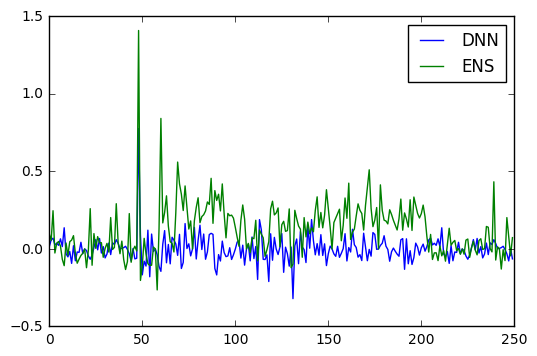

In [29]:
import matplotlib.pyplot as plt
#%matplotlib inline

plt.plot(range(n_tt), DNN_R_total_tt)
#plt.plot(range(n_tt), GBT_R_total_tt)
#plt.plot(range(n_tt), RAF_R_total_tt)
plt.plot(range(n_tt), ENS_R_total_tt)
plt.legend(('DNN', 'ENS'))
plt.show()

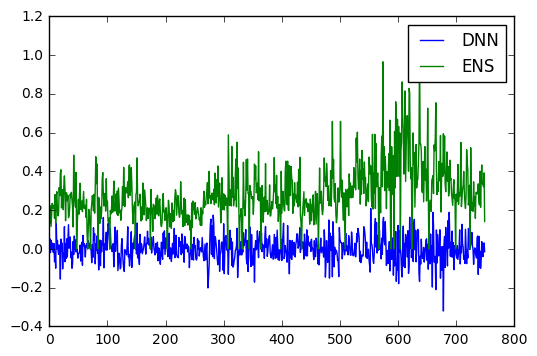

In [30]:
# Trading n_tn

c = n_lb
def Trade_tn(best_k, worst_k):
    R_L = np.zeros((n_tn, k))
    R_S = np.zeros((n_tn, k))
    
    for i in range(n_tn):
        # Rates of return of [long best k]
        R_L[i] =   B_n[c+i+lookforward, best_k[i]]  / B_n[c+i, best_k[i]]  - 1.0
        # Rates of return of [short worst k]
        R_S[i] = - B_n[c+i+lookforward, worst_k[i]] / B_n[c+i, worst_k[i]] + 1.0

        # Sum up
        R_L_sum = R_L.sum(axis=1)
        R_S_sum = R_S.sum(axis=1)
        R_total = R_L_sum + R_S_sum

    if tc_bool:
        #tc = ?
        #slippage = ?
        pass

    return R_total, R_L_sum, R_S_sum


DNN_R_total_tn, DNN_R_L_sum_tn, DNN_R_S_sum_tn = Trade_tn(DNN_best_k_tn, DNN_worst_k_tn)
GBT_R_total_tn, GBT_R_L_sum_tn, GBT_R_S_sum_tn = Trade_tn(GBT_best_k_tn, GBT_worst_k_tn)
RAF_R_total_tn, RAF_R_L_sum_tn, RAF_R_S_sum_tn = Trade_tn(RAF_best_k_tn, RAF_worst_k_tn)
ENS_R_total_tn, ENS_R_L_sum_tn, ENS_R_S_sum_tn = Trade_tn(ENS_best_k_tn, ENS_worst_k_tn)


plt.plot(range(n_tn), DNN_R_total_tn)
#plt.plot(range(n_tn), GBT_R_total_tn)
#plt.plot(range(n_tn), RAF_R_total_tn)
plt.plot(range(n_tn), ENS_R_total_tn)
plt.legend(('DNN', 'ENS'))
plt.show()

## 7. MODEL

## 8. REAL data

## 9. Reap

A prototype for future development